C:\Users\JRichards\AppData\Local\Temp\ipykernel_25556\149488120.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change() # JR: Futurewarning, but changing to fill_method=None changes output


           AAPL      AMZN      AVGO     BRK-B        FB      GOOG     GOOGL  \
AAPL   0.000862  0.000275  0.000332  0.000171  0.000246  0.000293  0.000287   
AMZN   0.000275  0.001218  0.000287  0.000105  0.000202  0.000278  0.000258   
AVGO   0.000332  0.000287  0.001267  0.000155  0.000218  0.000276  0.000265   
BRK-B  0.000171  0.000105  0.000155  0.000184  0.000103  0.000140  0.000129   
FB     0.000246  0.000202  0.000218  0.000103  0.000420  0.000216  0.000217   
GOOG   0.000293  0.000278  0.000276  0.000140  0.000216  0.000404  0.000395   
GOOGL  0.000287  0.000258  0.000265  0.000129  0.000217  0.000395  0.001124   
JPM    0.000207  0.000123  0.000237  0.000213  0.000133  0.000167  0.000133   
LLY    0.000139  0.000104  0.000128  0.000094  0.000099  0.000115  0.000108   
MSFT   0.000309  0.000294  0.000304  0.000141  0.000210  0.000289  0.000284   
NVDA   0.000457  0.000442  0.000580  0.000177  0.000319  0.000408  0.000394   
TSLA   0.000900  0.000403  0.000504  0.000166  0.000

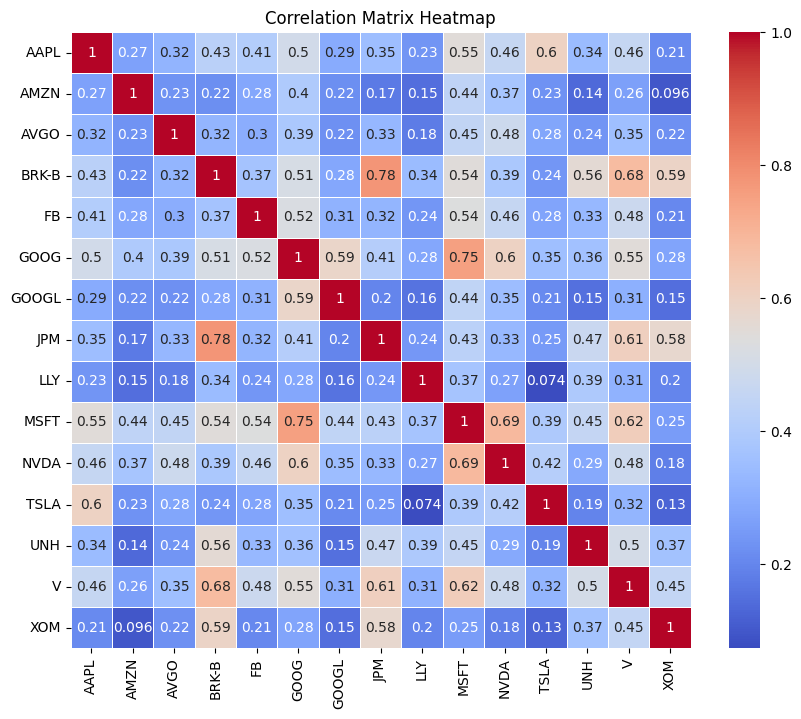

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


# Load the CSV file
df = pd.read_csv('combined_eod_data.csv')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert the data to numeric, ignoring errors for any non-numeric data
df = df.apply(pd.to_numeric, errors='coerce')
#print(df.head())

# Calculate daily percentage changes
returns = df.pct_change() # JR: Futurewarning, but changing to fill_method=None changes output 

# Drop the first row NaN values due to the pct_change calculation
returns.dropna(inplace=True)
# print(returns.head())
# returns.to_csv('returns pct_change standard.csv', index=True)

# Calculate the covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)

# Calculate the correlation matrix
corr_matrix = returns.corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


